# **Data and Analysis Plan: World Series Predictions**

- Justin Radist
- Suneet Pathangay
- Zhenzhen Liu
- Elijah Sandler

## Project Goal:

Our project aims to explore the relationship between various MLB team and individual player statistics and the performance of teams in the playoffs and World Series. We have chosen to focus on common batting and pitching statistics for teams and individual players over the last 25-30 years. We may also focus on other pieces of data such as payrolls, team injuries, fan base support and stadium dimensions. Specifically, we ask:
- What metrics - whether they be certain team statistics, individual player statistics, injuries, payrolls, fan bases, stadiums, etc. - have a material impact on playoff performance and World Series winners?
- Can we determine metrics that are greater predictors of World Series winners than regular season wins? Can we build a model that predicts these metrics for future seasons and uses these projections to predict future World Series winners?

We are using https://www.baseball-reference.com/ for our main data source, which we will webscrape from. We are not using any API.

## Pipeline Overview:

We have already written several functions for scraping the Baseball Reference website:
- build_player_url() and build_team_url()
    - Builds the URLs needed to access a certain player's or team's statistics page.
- get_batting_df() & get_pitching_df(()
    - Get tables of a team's batting and pitching statistics, respectively, for a given season.
- get_season_batting_df()
    - Get batting stats by team for a given season. We'll add a get_season_pitching_df(season) function soon.
- get_player_df()
     - Along with get_player_dict(), builds dataframes of a player's common careers stats table.

### Pipeline:

#### 1. Building URLs and Webscraping

In [1]:
# import statements
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
from bs4 import Comment

In [2]:
def build_player_url(player):
    """ Constructs the URL of any MLB player's Baseball Reference stat page
    
    Args:
        player (str): a baseball player's full name
    
    Returns:
        url (str): the URL that can be used to retrieve the given player's
        stats from BaseballReference.com
    """
    first_init = player[0]
    first_two_letters = player[0:2]
    player_name_list = player.split(' ')
    # get last name except for last letter. Gets position 1 instead of -1 in case of a Jr./Sr. or II/III
    last_name = player_name_list[1][:-1]
    
    url = f"https://www.baseball-reference.com/players/{first_init}/{last_name}{first_two_letters}01.shtml"
    return url

In [3]:
def build_team_url(team, year):
    """ Constructs the URL of any MLB team's Baseball Reference stat page for a single season
    
    Args:
        team (str): 3-letter abbreviation of one of the 30 current MLB teams in existence
        year (int): the year/season to get team data for
    
    Returns:
        url (str): the URL that can be used to retrieve the given team's
        stats for the given year from BaseballReference.com
    """
    url = f"https://www.baseball-reference.com/teams/{team}/{str(year)}.shtml"
    return url

In [4]:
# testing cell
player = 'carlos correa'
team = 'NYM'
season = '2022'
player_url = build_player_url(player)
team_url = build_team_url(team, season)

In [4]:
# CURRENTLY NOT NEEDED
def get_soup(url):
    """ gets a BeautifulSoup object of a MLB player's or team's BaseballReference.com
        page by webscraping the page's HTML code
    
    Args:
        url (str): the URL that can be used to retrieve the given player's or team's
        stats from BaseballReference.com
    
    Returns:
        soup (BeautifulSoup): a beautiful soup object of the given MLB
        player's or team's BaseballReference.com page
    """
    html = requests.get(url).text
    soup = BeautifulSoup(html)
    
    return soup

In [6]:
# testing cell
player_soup = get_soup(player_url)
time.sleep(4)
team_soup = get_soup(team_url)
time.sleep(4)

#### 2. Cleaning Data and Building Dataframes

In [5]:
dict_team_batting = defaultdict(lambda: dict())
def get_batting_df(team_code, dict_team_batting=dict_team_batting, year=2023):
    """ Gets the batting table for a given team. if table is not stored, adds it to dictionary 
    
    Args:
        team_code (str): short team abbreviation used by Baseball Reference
        dict_team_batting (dict): dictionary containing all queries we've made before
        year(int): the year we want data from, defaults to 2023

    Returns:
        dict_team_batting[year][team_code] (pd.DataFrame): dataframe of batting stats for given team and year
    """
    
    if team_code in dict_team_batting.keys():
        return dict_team_batting[year][team_code]
    
    else:
        url = f"https://www.baseball-reference.com/teams/{team_code}/{str(year)}.shtml"
        df_batting = pd.read_html(url)[0]
        time.sleep(4)
        
        df_filtered = pd.DataFrame()
        for idx in df_batting.index:
            try:
                int(df_batting.loc[idx, 'Rk'])
                df_filtered = pd.concat([df_filtered, df_batting.loc[idx, :]], axis=1)
            except(ValueError):
                pass
        
        
        dict_team_batting[year][team_code] = df_filtered.T
        
    return dict_team_batting[year][team_code]

In [8]:
# testing cell
get_batting_df('NYY')

,Rk,Pos,Name,Age,G,PA,AB,R,H,2B,...,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
0,1,C,Kyle Higashioka,33,92,260,242,24,57,13,...,.274,.413,.687,85,100,5,0,1,3,0
1,2,1B,Anthony Rizzo*,33,99,421,373,45,91,14,...,.328,.378,.706,94,141,10,12,0,1,1
2,3,2B,Gleyber Torres,26,158,672,596,90,163,28,...,.347,.453,.800,118,270,19,3,0,6,0
3,4,SS,Anthony Volpe,22,159,601,541,62,113,23,...,.283,.383,.666,81,207,10,5,1,2,0
4,5,3B,DJ LeMahieu,34,136,562,497,55,121,22,...,.327,.390,.718,96,194,14,3,0,2,2
5,6,LF,Oswaldo Cabrera#,24,115,330,298,35,63,11,...,.275,.299,.574,58,89,6,2,3,2,1
6,7,CF,Harrison Bader,29,84,310,288,40,69,11,...,.278,.365,.643,75,105,6,3,1,4,0
7,8,RF,Aaron Judge,31,106,458,367,79,98,16,...,.406,.613,1.019,175,225,5,0,0,3,9
8,9,DH,Giancarlo Stanton,33,101,415,371,43,71,13,...,.275,.420,.695,87,156,11,2,0,1,3
10,10,UT,Isiah Kiner-Falefa,28,113,361,326,39,79,12,...,.306,.340,.646,78,111,12,3,1,3,0


In [6]:
dict_team_pitching = defaultdict(lambda: dict())
def get_pitching_df(team_code, dict_team_pitching=dict_team_pitching, year=2023):
    """ Gets the pitching table for a given team. if table is not stored, adds it to dictionary 
    
    Args:
        team_code (str): short team abbreviation used by baseball reference
        dict_team_pitching (dict): dictionary containing all queries we've made before
        year(int): year we want data from, defaults to 2023
    Returns:
        dict_team_pitching[year][team_code] (pd.DataFrame): dataframe of pitching stats for given team and year
    """
    
    if team_code in dict_team_pitching[year].keys():
        return dict_team_pitching[year][team_code]
    
    else:
        url = f"https://www.baseball-reference.com/teams/{team_code}/{str(year)}.shtml"
        df_pitching = pd.read_html(url)[1]
        time.sleep(4)
        
        df_filtered = pd.DataFrame()
        for idx in df_pitching.index:
            try:
                int(df_pitching.loc[idx, 'Rk'])
                df_filtered = pd.concat([df_filtered, df_pitching.loc[idx, :]], axis=1)
            except(ValueError):
                pass
          
        dict_team_pitching[year][team_code] = df_filtered.T
        
    return dict_team_pitching[year][team_code]

In [10]:
# testing cell
get_pitching_df('BOS')

,Rk,Pos,Name,Age,W,L,W-L%,ERA,G,GS,...,WP,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W
0,1,SP,Brayan Bello,24,12,11,.522,4.24,28,28,...,1,668,107,4.54,1.338,9.5,1.4,2.6,7.6,2.93
1,2,SP,Kutter Crawford,27,6,8,.429,4.04,31,23,...,4,527,113,3.83,1.106,7.4,1.2,2.5,9.4,3.75
2,3,SP,Tanner Houck,27,6,10,.375,5.01,21,21,...,1,463,91,4.43,1.368,8.8,1.2,3.5,8.4,2.41
3,4,SP,Chris Sale*,34,6,5,.545,4.30,20,20,...,3,425,106,3.80,1.130,7.6,1.3,2.5,11.0,4.31
4,5,SP,James Paxton*,34,7,5,.583,4.50,19,19,...,5,411,101,4.68,1.313,8.7,1.7,3.1,9.5,3.06
6,6,CL,Kenley Jansen,35,3,6,.333,3.63,51,0,...,1,188,126,3.66,1.276,8.1,1.0,3.4,10.5,3.06
7,7,RP,Josh Winckowski,25,4,4,.500,2.88,60,1,...,2,367,158,3.91,1.423,9.5,1.0,3.3,8.8,2.65
8,8,RP,Chris Martin,37,4,1,.800,1.05,55,0,...,1,199,434,2.44,1.032,7.9,0.4,1.4,8.1,5.75
9,9,RP,Brennan Bernardino*,31,2,1,.667,3.20,55,6,...,3,216,143,3.41,1.303,8.5,0.7,3.2,10.3,3.22
10,10,RP,John Schreiber,29,2,1,.667,3.86,46,2,...,1,204,118,4.52,1.414,7.9,1.2,4.8,10.2,2.12


In [7]:
def get_season_batting_df(season):
    """ Gets a table of common batting stats organized by MLB team for a given season
    Args:
        season (int): the season to get data for
    
    Returns:
         df_season_batting (pd.DataFrame): a dataframe of batting stats by team for a season
    """
    url = f'https://www.baseball-reference.com/leagues/majors/{season}.shtml'
    
    df_season_batting = pd.read_html(url)[0]
    time.sleep(4)
    
    return df_season_batting

In [8]:
def get_player_dict(player_soup):
    """ creates a dictionary of all an baseball player's MLB stats
        by web scraping BaseballReference.com
    
    Args:
        player_soup (BeautifulSoup): a beautiful soup object of a MLB
        player's BaseballReference.com page
    
    Returns:
        player_dict (dict): a dictionary of all the given player's MLB
        stats, where the keys are the years played in the MLB
    """
    # build dictionary of player stats row by row (season by season) without knowing years they've played
    player_stats = player_soup.find_all(class_='row_summable', id='batting_standard')[0].find_all('tbody')[0].find_all(class_='full')
    player_dict = {}
    for item in player_stats:
        # list will add current year's stats to
        temp_list = []
        # get list of tags, where each tag is different stat for current year
        tds = item.find_all('td')
        # loop through the tags and add each tags' text (stat) to the temp list
        for td in tds:
            temp_list.append(td.text)
        # add current list of stats to the year they correspond to
        player_dict[item.find('th').text] = temp_list
    
    return player_dict

In [13]:
player_dict = get_player_dict(player_soup)

In [9]:
# get stat names (used for df col names). [1:] gets rid of 'Year'
header = player_soup.find_all(class_='row_summable')[0].find_all(attrs={'aria-label': True})[1:]
stat_names = []
for item in header:
    stat_names.append(item.text)

NameError: name 'player_soup' is not defined

In [9]:
def get_player_df(player_dict):
    """ creates a df of all a baseball player's MLB stats
    
    Args:
        player_soup (BeautifulSoup): a dictionary of a MLB
        player's career stats by season
    
    Returns:
        player_df (pd.DataFrame): a df of all the given player's MLB
        stats
    """
    player_df = pd.DataFrame()

    for year in player_dict:
        player_series = pd.Series(player_dict[year], index=stat_names)
        player_df = pd.concat([player_df, player_series.to_frame().T])

    player_df.index = player_dict.keys()
    
    return player_df

In [16]:
player_df = get_player_df(player_dict)
player_df.head()

,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,...,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos,Awards
2015,20,HOU,AL,99,432,387,52,108,22,1,...,.857,135,198,10,1,0,4,2,6,"MVP-24,RoY-1"
2016,21,HOU,AL,153,660,577,76,158,36,3,...,.811,124,260,12,5,0,3,5,*6/H,
2017,22,HOU,AL,109,481,422,82,133,25,1,...,.941,155,232,12,2,0,4,5,6/D,"AS,MVP-17"
2018,23,HOU,AL,110,468,402,60,96,20,1,...,.728,99,163,17,2,0,11,3,*6/D,
2019,24,HOU,AL,75,321,280,42,78,16,1,...,.926,137,159,8,2,0,4,0,6,


In [10]:
team_abbrevs_dict = {'Arizona Diamondbacks': 'ARI',
                     'Atlanta Braves': 'ATL',
                     'Baltimore Orioles': 'BAL',
                     'Boston Red Sox': 'BOS',
                     'Chicago Cubs': 'CHC',
                     'Chicago White Sox': 'CWS',
                     'Cincinnati Reds': 'CIN',
                     'Cleveland Guardians': 'CLE',
                     'Colorado Rockies': 'COL',
                     'Detroit Tigers': 'DET',
                     #'Florida Marlins': 'MIA',
                     'Houston Astros': 'HOU',
                     'Kansas City Royals': 'KAN',
                     'Los Angeles Angels': 'LAA',
                     'Los Angeles Dodgers': 'LAD',
                     'Miami Marlins': 'MIA',
                     'Milwaukee Brewers': 'MIL',
                     'Minnesota Twins': 'MIN',
                     'New York Mets': 'NYM',
                     'New York Yankees': 'NYY',
                     'Oakland Athletics': 'OAK',
                     'Philadelphia Phillies': 'PHI',
                     'Pittsburgh Pirates': 'PIT',
                     'San Diego Padres': 'SDP',
                     'San Francisco Giants': 'SFG',
                     'Seattle Mariners': 'SEA',
                     'St. Louis Cardinals': 'STL',
                     'Tampa Bay Rays': 'TBR',
                     'Texas Rangers': 'TEX',
                     'Toronto Blue Jays': 'TOR',
                     'Washington Nationals': 'WAS'}

## Visualizations:

This visualization plots how many World Series winners led the league in each stat during the regular season of the year they won the World Series.

In [28]:
# get the World Series information
table = pd.read_html("https://www.baseball-reference.com/postseason/world-series.shtml")
time.sleep(4)
ws_data = table[0]

# rename win and win1 to AL Wins and NL Wins
ws_data.rename(columns={ws_data.columns[2]: 'AL Wins'}, inplace=True)
ws_data.rename(columns={ws_data.columns[3]: 'NL Wins'}, inplace=True)

In [29]:
# build dictionary of World Series winners (and losers)
ws_winner_dict = {}
#ws_loser_dict = {}

for idx, row in ws_data.iterrows():
    if row['AL Wins'] == '4':
        ws_winner_dict[int(row['Year'])] = row['AL Winner']
        #ws_loser_dict[int(row['Year'])] = row['NL Winner']
    if row['NL Wins'] == '4':
        ws_winner_dict[int(row['Year'])] = row['NL Winner']
        #ws_loser_dict[int(row['Year'])] = row['AL Winner']

In [89]:
def seasonal_data(year):
    """ gets team batting and pitching data for a given season
    
    Args: 
        year (int): year of statistics
        
    Returns: 
        batting (df): dataframe of batting statistics
        pitching (df): dataframe of pitching statistics
        """
    
    url = f'https://www.baseball-reference.com/leagues/majors/{str(year)}.shtml'
    
    batting = pd.read_html(url)[0]
    # convert all values in table to float (except for team names)
    batting = pd.concat([batting.iloc[:30, 0], batting.iloc[:30, 1:].astype(float)], axis=1)
    
    """ for whatever reason, the html for the pitching table is commented out.
        so, we have to go in with bs4, find the tables in the comments, and then read that html. """
    
    response = requests.get(url)
    html_content = response.content

    # use bs4 to parse the HTML, including comments
    soup = BeautifulSoup(html_content, 'html.parser')

    # find all HTML comments
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))

    # extract tables from comments
    tables = []
    for comment in comments:
        comment_soup = BeautifulSoup(str(comment), 'html.parser')
        comment_tables = comment_soup.find_all('table')
        tables.extend(comment_tables) # not append

    pitching = pd.read_html(str(tables[1]))[0]
    # convert all values in table to float (except for team names)
    pitching = pd.concat([pitching.iloc[:30, 0], pitching.iloc[:30, 1:].astype(float)], axis=1)
    
    # clean tables
    batting_filtered = pd.DataFrame()
    for idx in batting.index:
        try:
            int(batting.loc[idx, '#Bat'])
            batting_filtered = pd.concat([batting_filtered, batting.loc[idx, :]], axis=1)
        except(ValueError):
            pass
        
    pitching_filtered = pd.DataFrame()
    for idx in pitching.index:
        try:
            int(pitching.loc[idx, '#P'])
            pitching_filtered = pd.concat([pitching_filtered, pitching.loc[idx, :]], axis=1)
        except(ValueError):
            pass
    
    # don't get timed out
    time.sleep(8.2)
    
    return batting, pitching
    #return batting_filtered.T, pitching_filtered.T

In [90]:
b, p = seasonal_data(2023)
p.head()

/Users/justinradist/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


,Tm,#P,PAge,RA/G,W,L,W-L%,ERA,G,GS,...,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W,LOB
0,Arizona Diamondbacks,34.0,28.5,4.70,84.0,78.0,0.519,4.47,162.0,162.0,...,6100.0,98.0,4.35,1.324,8.6,1.2,3.3,8.5,2.57,1050.0
1,Atlanta Braves,32.0,29.9,4.42,104.0,58.0,0.642,4.14,162.0,162.0,...,6135.0,108.0,4.10,1.302,8.4,1.2,3.3,9.5,2.84,1112.0
2,Baltimore Orioles,31.0,28.4,4.19,101.0,61.0,0.623,3.89,162.0,162.0,...,6098.0,106.0,3.98,1.243,8.3,1.1,2.9,8.9,3.03,1080.0
3,Boston Red Sox,33.0,30.0,4.79,78.0,84.0,0.481,4.52,162.0,162.0,...,6168.0,101.0,4.37,1.338,8.9,1.3,3.1,9.0,2.86,1117.0
4,Chicago Cubs,27.0,29.6,4.46,83.0,79.0,0.512,4.08,162.0,162.0,...,6085.0,110.0,4.16,1.283,8.3,1.1,3.2,8.6,2.68,1073.0


In [92]:
year = 2023
b, p = seasonal_data(2023)

/Users/justinradist/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [273]:
years = list(map(lambda x: 2023 - x, range(num_seasons)))
master_df = pd.DataFrame()

for year in years:
    # get batting and pitching tables by team for current season
    b, p = seasonal_data(year)
    # combine batting and pitching dfs for 1 season into 1 df
    current_year_df = pd.concat([b, p], axis=1)
    current_year_list = pd.Series(map(lambda x: year, range(len(b))), name='Season')
    # add column identifying what season the current data is from
    current_year_df = pd.concat([current_year_list.to_frame(), current_year_df], axis=1)
    # add column of teams' playoff success
    playoff_col = playoff_success_df.loc[year].reset_index(drop=True)
    playoff_col = pd.Series(playoff_col, name='Playoff Round')
    current_year_df = pd.concat([current_year_df, playoff_col.to_frame()], axis=1)
    # add current year's df to master df
    master_df = pd.concat([master_df, current_year_df])

# save master_df to a CSV file
master_df.to_csv('master_df.csv', index=False)

/Users/justinradist/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [275]:
pd.read_csv('master_df.csv').tail(40)

,Season,Tm,#Bat,BatAge,R/G,G,PA,AB,R,H,...,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W,LOB.1,Playoff Round
710,2000,Oakland Athletics,44.0,27.3,5.88,161.0,6432.0,5560.0,947.0,1501.0,...,103.0,4.61,1.498,9.6,1.0,3.9,6.0,1.57,1236.0,0
711,2000,Philadelphia Phillies,51.0,28.6,4.37,162.0,6273.0,5511.0,708.0,1386.0,...,98.0,4.81,1.458,9.1,1.3,4.0,7.0,1.75,1168.0,0
712,2000,Pittsburgh Pirates,46.0,28.3,4.90,162.0,6369.0,5643.0,793.0,1506.0,...,94.0,4.72,1.563,9.7,1.0,4.4,6.6,1.50,1279.0,0
713,2000,San Diego Padres,56.0,28.6,4.64,162.0,6291.0,5560.0,752.0,1413.0,...,95.0,4.84,1.434,8.9,1.2,4.0,6.6,1.65,1221.0,2
714,2000,Seattle Mariners,37.0,31.3,5.60,162.0,6444.0,5497.0,907.0,1481.0,...,101.0,4.65,1.440,9.0,1.0,4.0,6.2,1.57,1164.0,3
715,2000,San Francisco Giants,36.0,29.9,5.71,162.0,6418.0,5519.0,925.0,1535.0,...,102.0,4.38,1.437,9.0,0.9,3.9,6.7,1.73,1190.0,3
716,2000,St. Louis Cardinals,46.0,29.6,5.48,162.0,6369.0,5478.0,887.0,1481.0,...,107.0,4.77,1.401,8.8,1.2,3.8,6.9,1.82,1128.0,0
717,2000,Tampa Bay Devil Rays,51.0,30.1,4.55,161.0,6206.0,5505.0,733.0,1414.0,...,102.0,4.85,1.457,9.8,1.2,3.4,6.0,1.79,1147.0,0
718,2000,Texas Rangers,42.0,29.5,5.23,162.0,6364.0,5648.0,848.0,1601.0,...,91.0,5.21,1.640,10.6,1.3,4.2,5.8,1.39,1298.0,0
719,2000,Toronto Blue Jays,45.0,28.1,5.31,162.0,6326.0,5677.0,861.0,1562.0,...,98.0,4.84,1.513,10.1,1.2,3.5,6.1,1.75,1157.0,0


In [135]:
# this cells makes pseudo-master df of batting and pitching stats. Pseudo because only for 1 season

# combine batting and pitching dfs for 1 season into 1 df
pseudo_master_df = pd.concat([b, p], axis=1)
year_list = pd.Series(map(lambda x: 2023, range(len(b))), name='Season')
# add column identifying what season the current data is from
pseudo_master_df = pd.concat([year_list.to_frame(), pseudo_master_df], axis=1)
# add column of teams' playoff success
playoff_col = playoff_success_df.loc[year].reset_index(drop=True)
playoff_col = pd.Series(playoff_col, name='Playoff Round')
pseudo_master_df = pd.concat([pseudo_master_df, playoff_col.to_frame()], axis=1)

pseudo_master_df.head()

,Season,Tm,#Bat,BatAge,R/G,G,PA,AB,R,H,...,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W,LOB,Playoff Round
0,2023,Arizona Diamondbacks,54.0,27.4,4.60,162.0,6124.0,5436.0,746.0,1359.0,...,98.0,4.35,1.324,8.6,1.2,3.3,8.5,2.57,1050.0,4
1,2023,Atlanta Braves,53.0,27.9,5.85,162.0,6249.0,5597.0,947.0,1543.0,...,108.0,4.10,1.302,8.4,1.2,3.3,9.5,2.84,1112.0,2
2,2023,Baltimore Orioles,50.0,27.3,4.98,162.0,6123.0,5495.0,807.0,1399.0,...,106.0,3.98,1.243,8.3,1.1,2.9,8.9,3.03,1080.0,2
3,2023,Boston Red Sox,56.0,28.6,4.77,162.0,6174.0,5562.0,772.0,1437.0,...,101.0,4.37,1.338,8.9,1.3,3.1,9.0,2.86,1117.0,0
4,2023,Chicago Cubs,48.0,28.4,5.06,162.0,6220.0,5504.0,819.0,1399.0,...,110.0,4.16,1.283,8.3,1.1,3.2,8.6,2.68,1073.0,0


In [165]:
pseudo_master_df.columns

Index(['Season', 'Tm', '#Bat', 'BatAge', 'R/G', 'G', 'PA', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG',
       'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'LOB', 'Tm', '#P',
       'PAge', 'RA/G', 'W', 'L', 'W-L%', 'ERA', 'G', 'GS', 'GF', 'CG', 'tSho',
       'cSho', 'SV', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'SO', 'HBP',
       'BK', 'WP', 'BF', 'ERA+', 'FIP', 'WHIP', 'H9', 'HR9', 'BB9', 'SO9',
       'SO/W', 'LOB', 'Playoff Round'],
      dtype='object')

In [162]:
pseudo_master_df[['R/G', 'OPS', 'ERA', 'WHIP']].values.shape

(30, 5)

In [176]:
# random forest section
def rf_regressor(df, x_feat_list, y=None, max_depth=4, cross_val=False, n_splits=4):
    """ build a Random Forest Regressor model
    
    Args: 
        df (pd.DataFrame): dataframe to run
        x_feat_list (list): list of columns in df being used
        to predict the y feature
        y (str): column in df to predict
        max_depth (int): maximum depth each decision tree in the
        random forest should go
        cross_val (bool): if True, model should be cross validated
        n_splits (int): if model is meant to be cross validated, this
        is how many times to split the data when cross validating
    Returns:
        rf_reg (RandomForestRegressor): a random forest regressor model
    """
    if x_feat_list is None:
        # default x_feat_list, features to predict stats upon
        x_feat_list = ['R/G', 'BA', 'OPS', 'ERA', 'WHIP']
    if y is None:
        # default y, feature to estimate
        y = 'Playoff Round'

    # get columns of the features being used to predict given stat
    x = df[x_feat_list].values
    # get column of feature being estimated
    y_true = df[y].values
    #y_true = y_true.reshape(-1, 1)

    # initialize a rf regressor with a max depth of default 4
    rf_reg = RandomForestRegressor(n_estimators=100, max_depth=max_depth)
    
    if cross_val == False:
        rf_reg.fit(x, y_true)
        # predict y (from regression)
        #y_pred = rf_reg.predict(y_true)
        y_pred = rf_reg.predict(x)
        return rf_reg

    # construction of kfold object with default 4 folds
    kfold = KFold(n_splits=n_splits)
    # allocate an empty array to store predictions in
    y_pred = copy(y_true)
    
    # cross validate regression
    for train_idx, test_idx in kfold.split(x, y_true):
        # build arrays which correspond to x, y train/test
        x_test = x[test_idx, :]
        x_train = x[train_idx, :]
        y_true_train = y_true[train_idx]

        # modify rf_reg internal state to remember all training samples
        rf_reg.fit(x_train, y_true_train)

        # estimate Playoff Success for every team for 1/all seasons
        y_pred[test_idx] = rf_reg.predict(x_test)
    return rf_reg

In [262]:
def rf_classifier(df, x_feat_list, y=None, max_depth=4, n_splits=6):

    # default x_feat_list, features to predict stats upon
    #x_feat_list = ['R/G', 'BA', 'OPS', 'ERA', 'WHIP']
    #x_feat_list = ['R/G', 'BA', 'OPS', 'ERA', 'SO9']
    if y is None:
        # default y, feature to estimate
        y = 'Playoff Round'

    # get columns of the features being used to predict house price buckets
    x = df.loc[:, x_feat_list].values

    # get column of feature being estimated (price bucket)
    y_true = df.loc[:, y_feat].values

    # initialize a rf_classifier with a max depth of 3
    rf_class = RandomForestClassifier(n_estimators=100, max_depth=max_depth)

    # construction of kfold object with 10 folds
    kfold = KFold(n_splits=n_splits)

    # allocate an empty array to store predictions in
    y_pred = copy(y_true)

    for train_idx, test_idx in kfold.split(x, y_true):
        # build arrays which correspond to x, y train /test
        x_test = x[test_idx, :]
        x_train = x[train_idx, :]
        y_true_train = y_true[train_idx]

        # modify rf_classifier internal state to remember all training samples
        rf_class.fit(x_train, y_true_train)

        # estimate the price bucket each house falls into 
        y_pred[test_idx] = rf_class.predict(x_test)
    
    #return y_true, y_pred
    return rf_class

In [268]:
# CLASSIFIER CODE
x_feat_list = ['R/G', 'BA', 'OPS', 'ERA', 'SO9', 'WHIP', 'HR']
rf_clf_test = rf_classifier(pseudo_master_df, x_feat_list, y='Playoff Round')
#y_true_clf = rf_clf_test[0]
#y_pred_clf = rf_clf_test[1]

[4 1 3 0 2]


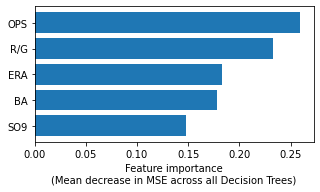

In [269]:
# CLASSIFIER CODE
plot_feat_import(x_feat_list, rf_clf_test.feature_importances_, limit=20)

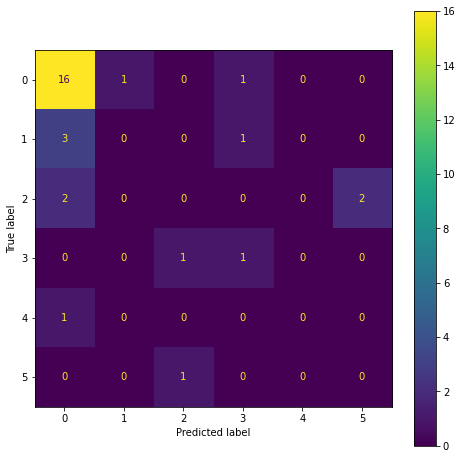

In [225]:
# CLASSIFIER CODE
# create confusion matrix
conf_mat = confusion_matrix(y_true=y_true_clf, y_pred=y_pred_clf)

# display confusion matrix
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true_clf))
conf_mat_disp.plot()

# set size of confusion matrix is displayed in
plt.gcf().set_size_inches(8, 8)

# turn off grid seaborn turns on by default
plt.grid(False)

In [221]:
# CLASSIFIER CODE
# returns percent of predictions that are accurate (as a decimal)
accuracy_score(y_true_clf, y_pred_clf)

0.5666666666666667

In [183]:
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=4)
x = pseudo_master_df[x_feat_list].values
y_true = pseudo_master_df['Playoff Round'].values
rf_reg.fit(x, y_true)
y_pred = rf_reg.predict(x)
y_pred

array([2.49166667, 2.63005556, 1.57279731, 1.08558333, 0.90446032,
       0.01      , 0.50958333, 0.47856746, 0.12      , 0.1110119 ,
       2.40750763, 0.        , 0.13125   , 2.35604731, 0.98734127,
       0.62567857, 1.35137271, 0.12      , 0.1335119 , 0.01      ,
       2.53338065, 0.        , 0.17681319, 0.46806319, 0.0535119 ,
       0.5       , 1.69139255, 3.84      , 1.17594811, 0.39666667])

In [186]:
rf_reg.show()

AttributeError: 'RandomForestRegressor' object has no attribute 'show'

In [177]:
#x_feat_list = ['R/G', 'H', 'HR', 'BA', 'OPS', 'ERA', 'WHIP', 'SO9'] keep commented out until rename H/HR cols
x_feat_list = ['R/G', 'BA', 'OPS', 'ERA', 'WHIP']
y_feat = 'Playoff Round'
rf_test = rf_regressor(pseudo_master_df, x_feat_list, y_feat)
plot_feat_import(x_feat_list, rf_test.feature_importances_)

ValueError: Expected 2D array, got 1D array instead:
array=[4. 2. 2. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 2. 1. 1. 2. 0. 0. 0. 3. 0. 0. 0.
 0. 0. 1. 5. 1. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [239]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None, regressor=True):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value
        regressor (bool): if True, xlabel says MSE instead of Gini
    
    Returns:
        None
    """
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        print(idx)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    if regressor == True:
        plt.xlabel('Feature importance\n(Mean decrease in MSE across all Decision Trees)')
    else:
        plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')
    plt.show()
    return None

In [ ]:
# PUT ON HOLD UNTIL MAKE RANDOM FOREST WORK FOR 1 SEASON
# master stat table with batting, pitching, and playoff success data for every team each of last 25 seasons
num_seasons = 25
years = list(map(lambda x: 2023 - x, range(num_seasons)))
# initialize column that'll denote what year each row in master df is from
year_col = []

for year in years:
    # add current year to year_col 30x
    year_list = list(map(lambda x: year, range(30)))
    year_col.append()

for year in years:
    temp_slice = playoff_data[playoff_data['Series'].str.contains(str(year), na=False)]
    year_success = []
    for team in team_abbrevs_dict.keys():
        # check if team won World Series
        if ws_winner_dict[int(year)] == team:
            year_success.append(5)
        # if team didn't win World Series, check if they made it to World Series
        elif team in temp_slice.iloc[0,2]:
        #elif team in temp_slice['Matchup'][0]:
            year_success.append(4)
        # if team didn't make it to World Series, check if they made it to Championship Series (CS)
        elif temp_slice.iloc[1:3, 2].str.count(team).sum() > 0:
        #elif temp_slice['Matchup'][1:3].str.count(team).sum() > 0:
            year_success.append(3)
        # if team didn't make it to CS, check if they made it to Division Series (DS)
        elif temp_slice.iloc[3:7, 2].str.count(team).sum() > 0:
        #elif temp_slice['Matchup'][3:7].str.count(team).sum() > 0:
            year_success.append(2)
        # if team didn't make it to DS, check if they made it to Wild Card (WC) round
        elif temp_slice.iloc[7:, 2].str.count(team).sum() > 0:
        #elif temp_slice['Matchup'][7:].str.count(team).sum() > 0:
            year_success.append(1)
        # if team didn't make playoffs, append 0
        else:
            year_success.append(0)

    year_series = pd.Series(year_success)
    playoff_success_df = pd.concat([playoff_success_df, year_series.to_frame().T])

# make df rows the seasons, make columns the teams/abbrevs, cells all contain 0, 1, 2, 3, 4, or 5
playoff_success_df.columns = list(team_abbrevs_dict.values())
playoff_success_df.index = years

In [13]:
def ws_winner_leading_data(team, year, num_teams=1):
    """ Get regular season stat leading data from a World Series winner
        
    Args:
        team (string): the name of the team
        year (int or string): the year that the team won the World Series
        num_teams (int): the lowest rank in the MLB a World Series winner can be in a stat to be considered a
        "leader" in that stat category (e.g., if num_teams is 3, then a World Series winner must have had one of
        the 3 highest stat values of any team in the MLB that season to be considered a "leader")
        
    Returns:
        None
    """
    # get table of aggregated batting data by team for a single season
    batting_table, _ = seasonal_data(year)
    time.sleep(4)
    
    batting_table.drop('G', axis=1, inplace=True)
    
    # loop through all stats in table
    for stat in list(batting_table.columns[3:]):
        # for each stat, convert its column of values to a list and sort in descending order
        stat_list = list(batting_table[stat])
        stat_list.sort(reverse=True)
        # find the cutoff stat value
        cutoff = stat_list[num_teams - 1]
        
        # if WS winner met/exceeded cutoff stat value, add 1 to the dict count of the current stat
        if (batting_table[batting_table[stat] >= cutoff]['Tm'] == team).any():
            if stat in stat_counts_dict.keys():
                stat_counts_dict[stat] += 1
            else:
                stat_counts_dict[stat] = 1
        
    return None

In [ ]:
# dictionary of counts of last 25 WS winners that were top 3 in the MLB in each batting stat
stat_counts_dict = {}
year_count = 0
for year, team in ws_winner_dict.items():
    if year_count > 25:
        break
    ws_winner_leading_data(team, year, num_teams=3)
    year_count += 1

stat_counts_dict

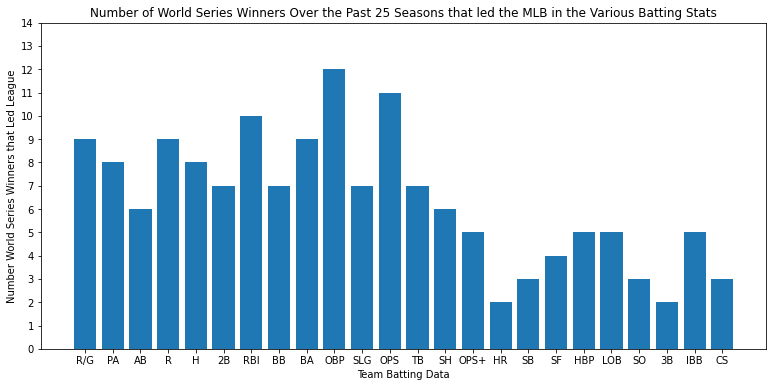

In [31]:
# create bar chart of stats and how often World Series winners led the league in them
plt.bar(stat_counts_dict.keys(), stat_counts_dict.values())
plt.yticks(list(range(15)))

plt.xlabel('Team Batting Data')
plt.ylabel('Number World Series Winners that Led League')
plt.title('Number of World Series Winners Over the Past 25 Seasons that led the MLB in the Various Batting Stats')
plt.gcf().set_size_inches(13, 6)
plt.show()

# 1. Use random forest to find out which stats impact each round win most
# 2. Write classifier function (maybe decision tree) to predict if a team will win first round of playoffs (cell value >= 2) based on certain stats. In order to do this need first to write a generalized code that gets stat rank for any team in any season (simpler version can just check if above or below MLB average)

In [33]:
playoff_data = pd.read_html('https://www.baseball-reference.com/postseason/')[0]

In [34]:
# rename columns
playoff_data.rename(columns={playoff_data.columns[1]: 'Series Outcome'}, inplace=True)
playoff_data.rename(columns={playoff_data.columns[2]: 'Matchup'}, inplace=True)

In [35]:
year = 2023
temp_slice = playoff_data[playoff_data['Series'].str.contains(str(year), na=False)]
temp_slice.iloc[0:3, 2].str.count('Texas Rangers').sum()

2

In [36]:
# get playoff success for all teams for the past 25 seasons
num_seasons = 25
years = list(map(lambda x: 2023 - x, range(num_seasons)))
year_success = []
playoff_success_df = pd.DataFrame()

for year in years:
    temp_slice = playoff_data[playoff_data['Series'].str.contains(str(year), na=False)]
    year_success = []
    for team in team_abbrevs_dict.keys():
        # check if team won World Series
        if ws_winner_dict[int(year)] == team:
            year_success.append(5)
        # if team didn't win World Series, check if they made it to World Series
        elif team in temp_slice.iloc[0,2]:
        #elif team in temp_slice['Matchup'][0]:
            year_success.append(4)
        # if team didn't make it to World Series, check if they made it to Championship Series (CS)
        elif temp_slice.iloc[1:3, 2].str.count(team).sum() > 0:
        #elif temp_slice['Matchup'][1:3].str.count(team).sum() > 0:
            year_success.append(3)
        # if team didn't make it to CS, check if they made it to Division Series (DS)
        elif temp_slice.iloc[3:7, 2].str.count(team).sum() > 0:
        #elif temp_slice['Matchup'][3:7].str.count(team).sum() > 0:
            year_success.append(2)
        # if team didn't make it to DS, check if they made it to Wild Card (WC) round
        elif temp_slice.iloc[7:, 2].str.count(team).sum() > 0:
        #elif temp_slice['Matchup'][7:].str.count(team).sum() > 0:
            year_success.append(1)
        # if team didn't make playoffs, append 0
        else:
            year_success.append(0)

    year_series = pd.Series(year_success)
    playoff_success_df = pd.concat([playoff_success_df, year_series.to_frame().T])

# make df rows the seasons, make columns the teams/abbrevs, cells all contain 0, 1, 2, 3, 4, or 5
playoff_success_df.columns = list(team_abbrevs_dict.values())
playoff_success_df.index = years

In [527]:
test = pd.DataFrame(playoff_success_df.loc[2023])
team_data_2023 = seasonal_data(2023)

In [208]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from copy import copy
from sklearn.model_selection import KFold
from sklearn import tree

In [42]:
# decision tree section
def train_dec_tree(year, y_df, max_depth=3, x_stat_list=None, plot=True):
    """ trains a decision tree classifier, optionally prints graph
    
    Args:
        df (pd.DataFrame): dataframe to train on
        max_depth (int): max depth of decision tree
        x_feat_list (list): list of input stats
        plot (bool): toggles graph output (default: True)
        
    Returns:
        dec_tree_clf (DecisionTreeClassifier): trained
            decicision tree
    """
    
    if x_stat_list is None:
        # default x_feat_list
        x_stat_list = ['R/G', 'HR', 'H', 'BA', 'OPS']

    x_df = seasonal_data(year)
    
    # extract data from dataframe
    x = x_df.loc[:, x_stat_list].values
    y = y_df.loc[year].values
    
    # build decision tree classifier
    dec_tree_clf = tree.DecisionTreeClassifier(max_depth=max_depth)

    # fit data
    dec_tree_clf = dec_tree_clf.fit(x, y)
    
    # plot figure of decision tree
    if plot:
        # initialize empty figure (plot_tree sets text size to fill given figure
        # if we resize figure afterwards text size remains too small)
        plt.figure()
        plt.gcf().set_size_inches(15, 10)
        
        # 'plot' decision tree
        tree.plot_tree(dec_tree_clf, 
                       feature_names=x_stat_list)
    
    return dec_tree_clf


DecisionTreeClassifier(max_depth=3)

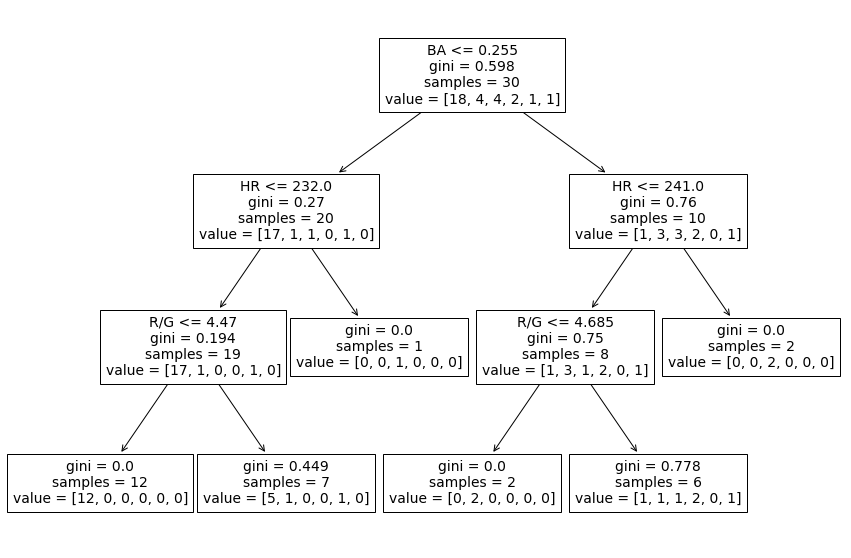

In [536]:
train_dec_tree(2023, playoff_success_df)

As you can see in the graph above, for every batting stat, at most 3 of the last 10 World Series winners led the league in it the year they won. This is actually a greater percentage than the number of teams that led the MLB in regular season wins the year they won the World Series, which is somewhat promising for our project. One next step could be to expand from only counting World Series winners that led the entire MLB in a stat to counting World Series winners that were one of the top 3 or 5 teams in the MLB for a stat that season. This is likely to increase the counts substantially while still providing relevant info, since top 5 out of 30 teams in still in the highest quintile.

The visualization below displays scatter plots with 2 sets of data points on the each plot: 1 color for the mean values by season, a different color for the set of values for World Series winners by season. We are looking to see if World Series winners consistently had well-above average values for any stat, which would indicate there might be some relationship between that stat and playoff success.

In [25]:
seasons = []
batting_stats = {'H': [],
                'HR': [],
                'RBI': [],
                'BA': [],
                'OPS': []}

# loop backwards through the past n seasons
for i in range(10):
    season = 2023 - i
    seasons.append(season)
    # pull df for current loop's season, set team name as the index
    df_season_batting = get_season_batting_df(season).set_index('Tm')
    time.sleep(4)
    # loop through all the stats in the dictionary initialized above
    for stat in list(batting_stats.keys()):
        # get the average team value for the current stat in the current season
        avg_stat_val = df_season_batting[stat][:30].astype(float).mean()
        
        # get the value for the current stat for the team that won the World Series in the current loop's season
        ws_winner = ws_winners_dict[season]
        ws_winner_stat_val = float(df_season_batting.loc[ws_winner][stat])
        
        # create 2-item list of mean stat value and World Series winner stat value for the current season
        temp_stat_list = [round(avg_stat_val, 3), round(ws_winner_stat_val, 3)]
        # add the 2-item list to list of the respective stat in the batting stats dictionary
        batting_stats[stat].append(temp_stat_list)

KeyboardInterrupt: 

In [ ]:
# plot mean team and WS winner values for each stat by season
sns.set_style('darkgrid')
for stat, values in batting_stats.items():
    temp_array = np.array(values)
    plt.scatter(seasons, temp_array[:, 0], label='Mean Value')
    plt.scatter(seasons, temp_array[:, 1], label='WS Winner Value')
    plt.xticks(seasons)
    plt.legend(bbox_to_anchor=(1.4, 1))
    plt.xlabel('Season')
    plt.ylabel(stat.capitalize())
    plt.title(f'Mean and WS Winner {stat.capitalize()} Values by Season')
    plt.show()

Almost all World Series winners have been above average in each of the above 5 batting statistics over the last 10 seasons. This supports our conclusions from the first visualization, which is that World Series winners perform well in these categories and that they may be better at predicting playoff success than regular season wins. Another next step will be to look at pitching stats in this same manner.

## Analysis/ML Plan:

The model that we feel that will be most appropriate for this would be a multi variate regression model to calculate the playoff performance and the chance of a team winning the World Series. Further more, we would figure out which which metrics are the greatest predictors of World Series winners. We can investigate linear regression with variety of inputs and predictors such as individual player statistics,payrolls,and injuries to see if we can accuractely predict whether a team will win the World Series. All of these factors could definitely play a roll in our model, however the one that stands out the most would probably be player statistics. Some player statistics that could have a huge impact woould be important stats such as batting average. It would also be important to consider other forms of regresison such as polynomial regresison. In conclusion, we will probably ending using a multi variate regression model to calculate playoff performances.

However, we recognize that playoff performance is a qualitative data point (i.e., "won World Series," "lost in NLCS," etc.), and while it can be quantified (e.g., made playoffs = 1, won Wild Card round = 2, ..., won World Series = 5), there's only a few possible outcomes, which may make regression difficult to implement usefully. Therefore, we expect we might need to switch to more qualitative ML models such as multivariate perceptrons, decision trees, random forests, etc. to get higher utility results. For instance, we might use a team's batting average, OPS, pitching staff ERA, and pitching staff WHIP to predict whether a team will make it to the playoffs - if they do, then predict whether a team will win the Wild Card round ... - until eventually, the remaining teams will be used to predict which will win the World Series.  